# Westeros Tutorial: Running MESSAGE in Recursive Dynamic Mode

While considering the full time horizon in a single run is useful for a long-term energy systems planning, the recursive dynamic approach can provide insights that reflect the relevant foresight windows decision makers can have in making adaptive and robust planning.

In addition to running the model with the perfect foresights, MESSAGE can also be run using the recursive dynamic approach. Here, the model is run iteratively throughout the periods with key decision variables from the previous periods, or iterations, are fixed so that new informations do not alter decisions that are already made in the previous periods. These variables
include $CAP$ , $CAP\_NEW$, $ACT$, and $EXT$. 

In this tutorial, we will implement the recursive dynamic mode on Westeros baseline scenario. Hence, before we start, we have to make sure that we can successfully run the baseline scenarion (``westeros_baseline.ipynb``).

Let's start with importing all the libraries we need and connect to the `ixmp` platform.

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import ixmp
import message_ix

from message_ix.util import make_df
from message_ix.tools.add_tech import add_tech


%matplotlib inline

mp = ixmp.Platform("local")

## `baseline` scenario with recursive dynamic mode

In [2]:
# cloning baseline scenario and crate 
model = "Westeros Electrified"

base = message_ix.Scenario(mp, model=model, scenario="baseline")
scen = base.clone(
    model,
    "baseline_recursive-dynamic",
    "introducing recursive dynamic mode",
    keep_solution=False,
)
scen.check_out()

year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = scen.set("year")
country = "Westeros"

**Time to Solve the Model**

In perfect foresight mode, the solve statement we add is `scen.solve()` without any additional arguments. By default, this will tell MESSAGE to run in the perfect foreseight mode. To run MESSAGE using the recursive dynamic approach, we need to add `gams_args =["--foresight=X"]` argument to the solve statement, with `X` being the length of the foresight windows. This will pass the argument directly to `GAMS`, overiding the default values set in `MESSAGE_master.gms` and `model_setup.gms` scripts. Here, let's use `X=1` as an example. 

Similarly, technology cost learning module can be activated by setting `learningmode` value to 1. This can also be done by passing `"--learningmode=1"` GAMS argument in the solve statement, i.e., `gams_args =["--foresight=X","--learningmode=1"]`. It is important to note that the learning module lives under the recursive dynamic module. Hence, this module needs to be active if learning module is used.

In [3]:
scen.commit(comment="Introducing recursive dynamic mode in MESSAGE")
scen.set_as_default()

scen.solve(gams_args =["--foresight=1"])

scen.var("OBJ")["lvl"]

159025.828125

## `emission_bound` scenario with adaptive optimization mode

In [4]:
# cloning baseline scenario and crate 
model = "Westeros Electrified"

bound_base = message_ix.Scenario(mp, model=model, scenario="emission_bound")
bound_scen = bound_base.clone(
    model,
    "emission-bound_adaptive",
    "introducing adaptive optimisation",
    keep_solution=False,
)
bound_scen.check_out()

year_df = bound_scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = bound_scen.set("year")
country = "Westeros"

In [5]:
bound_scen.commit(comment="Introducing recursive dynamic mode in MESSAGE")
bound_scen.set_as_default()

bound_scen.solve(gams_args = ["--foresight=3"])

bound_scen.var("OBJ")["lvl"]

191510.796875

## `emission_bound` scenario with adaptive optimisation and learning mode

In [6]:
# cloning baseline scenario and crate 
learning_scen = bound_base.clone(
    model,
    "emission-bound_adaptive-learning",
    "introducing adaptive optimisation with learning",
    keep_solution=False,
)
learning_scen.check_out()

year_df = learning_scen.vintage_and_active_years()
vintage_years, act_years = year_df["year_vtg"], year_df["year_act"]
model_horizon = learning_scen.set("year")
country = "Westeros"

In [7]:
learning_scen.add_set("newtec","wind_ppl")
learning_scen.set("newtec")

,technology
0,wind_ppl


In [8]:
learning_pars = {
    "alpha"          : 0.9,
    "beta_unit"      : 0.7,
    "beta_proj"      : 0,
    "gamma_unit"     : 0.03,
    "gamma_proj"     : 0.0,
    "inv_cost_refidx": 1,
    "knref_unit"     :30,
    "sizeref_unit"   : 1,
    "sizeref_proj"   :10,
}

for key,val in learning_pars.items():
    df_par = make_df(key,
                     technology = "wind_ppl",
                     value = val,
                     unit = "-"
                    )
    learning_scen.add_par(key,df_par)

In [9]:
learning_scen.par("alpha")

,technology,value,unit
0,wind_ppl,0.9,-


In [10]:
learning_scen.commit(comment="Introducing recursive dynamic mode in MESSAGE")
learning_scen.set_as_default()

learning_scen.solve(gams_args = ["--foresight=3","--learningmode=1"])

print("OBJ without learning:", bound_scen.var("OBJ")["lvl"])
print("OBJ with learning   :", learning_scen.var("OBJ")["lvl"])

OBJ without learning: 191510.796875
OBJ with learning   : 178483.546875


### Let's compare the results

## With learning

<IPython.core.display.Javascript object>

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

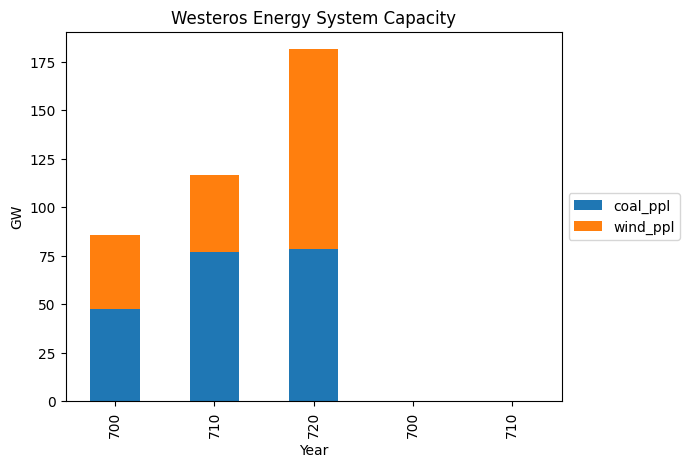

In [11]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(learning_scen)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"], ya=[700, 710, 720])
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

## Without learning

<Axes: title={'center': 'Westeros Energy System Capacity'}, xlabel='Year', ylabel='GW'>

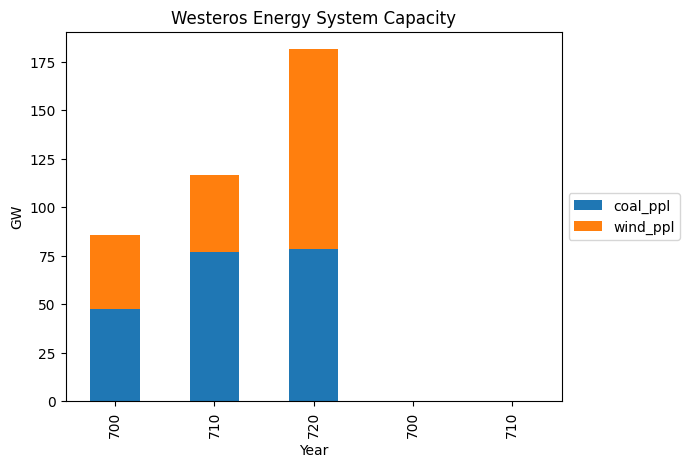

In [12]:
from message_ix.report import Reporter
from message_ix.util.tutorial import prepare_plots

# Create a Reporter object to describe and carry out reporting
# calculations and operations (like plotting) based on `scenario`
rep = Reporter.from_scenario(bound_scen)

# "prepare_plots" enables several to describe reporting operations, e.g.
# "plot activity", "plot capacity", or "plot prices"
# See message_ix/util/tutorial.py for more information
prepare_plots(rep)
rep.set_filters(t=["coal_ppl", "wind_ppl"], ya=[700, 710, 720])
# Create a different plot. The same filters are still active.
rep.get("plot capacity")

## Close the connection to the database

In [13]:
mp.close_db()